# Import Libraries

In [1]:
import calendar
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve, precision_score
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
#from lightgbm import LGBMClassifierx

# Import Dataset

In [2]:
data = pd.read_csv("startup_data_1.csv")
data.head()

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,...,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,...,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,...,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,...,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,...,c:65806,1,1,0,0,0,0,1.0000,1,closed


In [3]:
list(data.columns)

['Unnamed: 0',
 'state_code',
 'latitude',
 'longitude',
 'zip_code',
 'id',
 'city',
 'Unnamed: 6',
 'name',
 'labels',
 'founded_at',
 'closed_at',
 'first_funding_at',
 'last_funding_at',
 'age_first_funding_year',
 'age_last_funding_year',
 'age_first_milestone_year',
 'age_last_milestone_year',
 'relationships',
 'funding_rounds',
 'funding_total_usd',
 'milestones',
 'state_code.1',
 'is_CA',
 'is_NY',
 'is_MA',
 'is_TX',
 'is_otherstate',
 'category_code',
 'is_software',
 'is_web',
 'is_mobile',
 'is_enterprise',
 'is_advertising',
 'is_gamesvideo',
 'is_ecommerce',
 'is_biotech',
 'is_consulting',
 'is_othercategory',
 'object_id',
 'has_VC',
 'has_angel',
 'has_roundA',
 'has_roundB',
 'has_roundC',
 'has_roundD',
 'avg_participants',
 'is_top500',
 'status']

# Data Cleaning

In [4]:
# Define the data cleaning function
def clean_data(data):
    
    # Count initial number of rows
    initial_row_count = data.shape[0]
     
    data = (
            # Drop columns that are not needed
            data.drop(columns=["Unnamed: 0", "latitude", "longitude", "id", "Unnamed: 6", 
                               "object_id", "labels", "state_code.1", "closed_at", "state_code", "category_code"])
        
            # Transform status into binary
            .assign(status=lambda x: (x["status"] == "acquired").astype(int)) 
            
            # One-hot encode city and zip_code
            .pipe(pd.get_dummies, columns=['city', 'zip_code'], prefix=['city', 'zip_code']) 
            
            # Convert dates and create new columns
            .assign(founded_at=lambda x: pd.to_datetime(x['founded_at']),
                      first_funding_at=lambda x: pd.to_datetime(x['first_funding_at']),
                      last_funding_at=lambda x: pd.to_datetime(x['last_funding_at']),
                      amt_days_bw_found_first_fund=lambda x: (x['first_funding_at'] - x['founded_at']).dt.days,
                      founding_month=lambda x: x['founded_at'].dt.month) 
            
            # Drop the original date columns
            .drop(columns=['founded_at', 'first_funding_at', 'last_funding_at']) 
            
            # Drop rows with NA values
            .dropna() 
           )
    
    # Calculate the number and percentage of rows dropped
    rows_dropped = initial_row_count - data.shape[0]
    dropped_percentage = (rows_dropped / initial_row_count) * 100

    # Display the number and percentage of rows dropped
    print(f"Dropped {rows_dropped} rows due to missing values ({dropped_percentage:.2f}% of total).")

    # Export the cleaned data
    data.to_csv('1102_startup_data_cleaned.csv', encoding='utf-8', index=False)
    
    return data

# Clean the loaded data
data_clean = clean_data(data)

# Display the shape and columns of the cleaned data
print(f"Data shape: {data_clean.shape}")
#print(f"Data columns: {list(data_clean.columns)}")

Dropped 152 rows due to missing values (16.47% of total).
Data shape: (771, 638)


# Preliminary Analysis

<Figure size 1200x800 with 0 Axes>

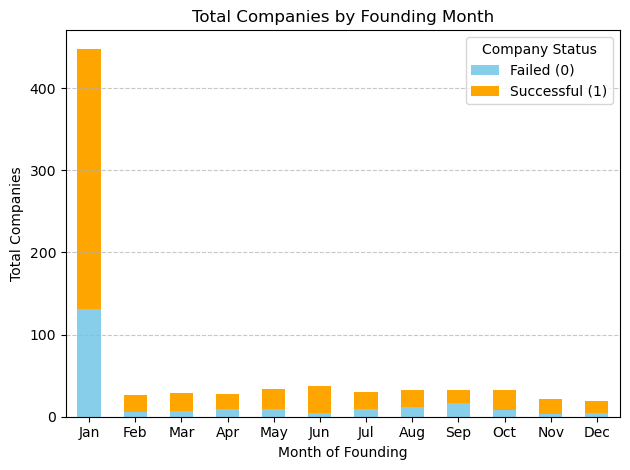

In [5]:
# Plotting without percentages
plt.figure(figsize=(12, 8))
grouped_data = data_clean.groupby('founding_month')['status'].value_counts().unstack().fillna(0)
grouped_data.plot(kind='bar', stacked=True, color=['skyblue', 'orange'])

# Adding labels and title
plt.xlabel('Month of Founding')
plt.ylabel('Total Companies')
plt.title('Total Companies by Founding Month')

# Customizing ticks
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation='horizontal')

# Adding legend and grid
plt.legend(title='Company Status', labels=['Failed (0)', 'Successful (1)'], loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.savefig('Total_Companies_by_Founding_Month')
plt.show()


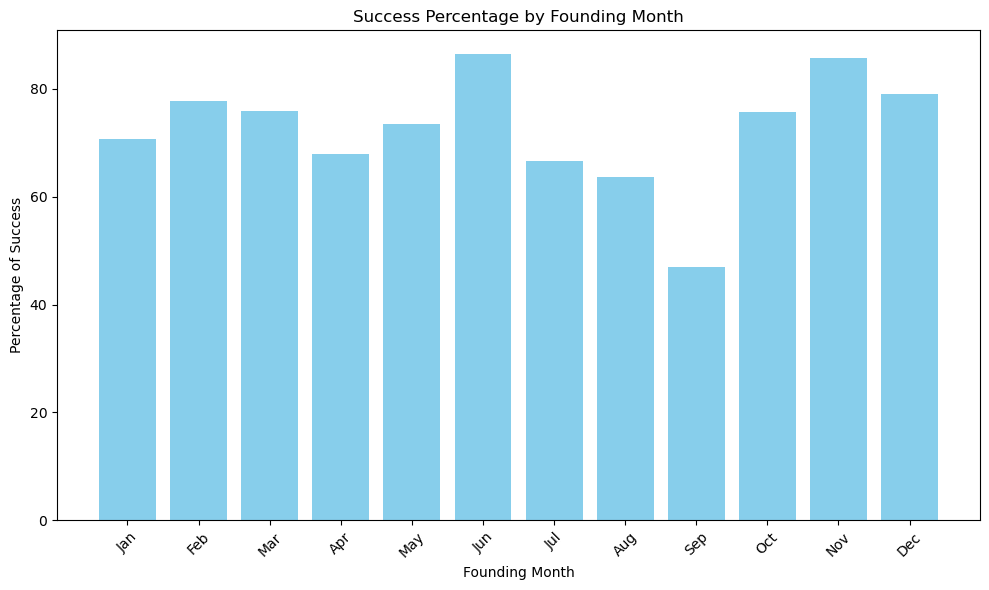

In [6]:
# Rename columns for clarity
grouped_data = grouped_data.rename(columns={0: 'Failures', 1: 'Successes'})

# Calculate the percentage of success
grouped_data['Success Percentage'] = grouped_data.apply(lambda x: 100 * x['Successes'] / (x['Successes'] + x['Failures']), axis=1)

# Reset index to use 'founding_month' as a column
grouped_data = grouped_data.reset_index()

# Assign correct month values
grouped_data['founding_month'] = grouped_data['founding_month'].apply(lambda x: calendar.month_abbr[x])

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(grouped_data['founding_month'], grouped_data['Success Percentage'], color='skyblue')

# Adding labels and title
plt.xlabel('Founding Month')
plt.ylabel('Percentage of Success')
plt.title('Success Percentage by Founding Month')

# Ensure all month labels are shown on x-axis
plt.xticks(ticks=range(len(grouped_data['founding_month'])), labels=grouped_data['founding_month'], rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig("Success_rate_by_funding_month")
plt.show()

checking if the month of founding have an effect on the success = No

### Understanding frequency of numerical variables

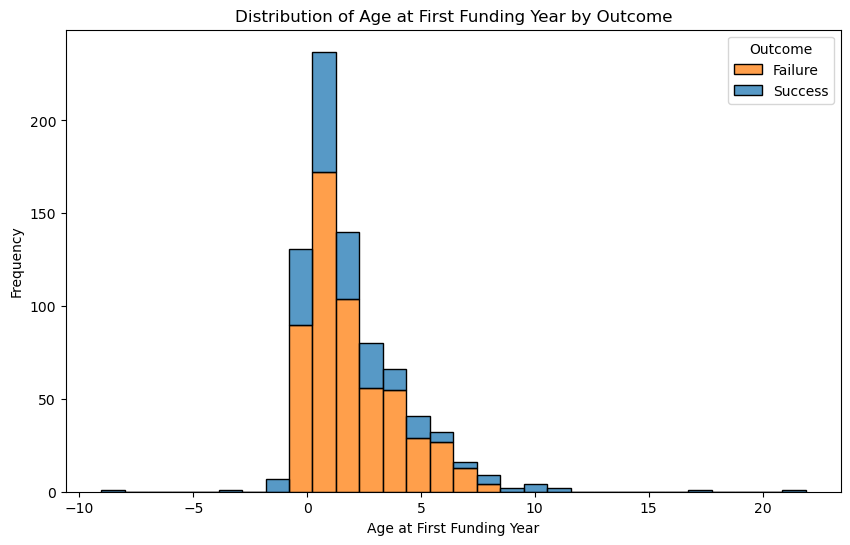

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Let's assume 'data_clean' has a column named 'success' with binary values
# where 1 indicates success and 0 indicates failure.

plt.figure(figsize=(10, 6))

# Plot a stacked histogram with differentiation for success and failure
sns.histplot(data=data_clean, x='age_first_funding_year', bins=30, kde=False, hue='status', multiple='stack')

plt.title('Distribution of Age at First Funding Year by Outcome')
plt.xlabel('Age at First Funding Year')
plt.ylabel('Frequency')
plt.legend(title='Outcome', labels=['Failure', 'Success'])
plt.savefig("Age_first_funding_by_outcome")
plt.show()

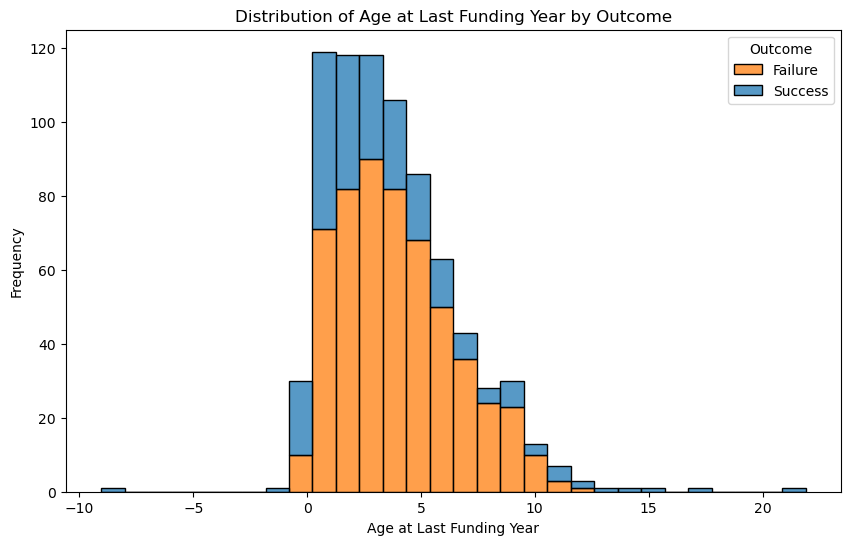

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data_clean' has a binary 'success' column.

plt.figure(figsize=(10, 6))

# Plot the stacked histogram for 'age_last_funding_year'
sns.histplot(data=data_clean, x='age_last_funding_year', bins=30, kde=False, hue='status', multiple='stack')

plt.title('Distribution of Age at Last Funding Year by Outcome')
plt.xlabel('Age at Last Funding Year')
plt.ylabel('Frequency')
plt.legend(title='Outcome', labels=['Failure', 'Success'])
plt.savefig("Age_last_funding_by_outcome")
plt.show()

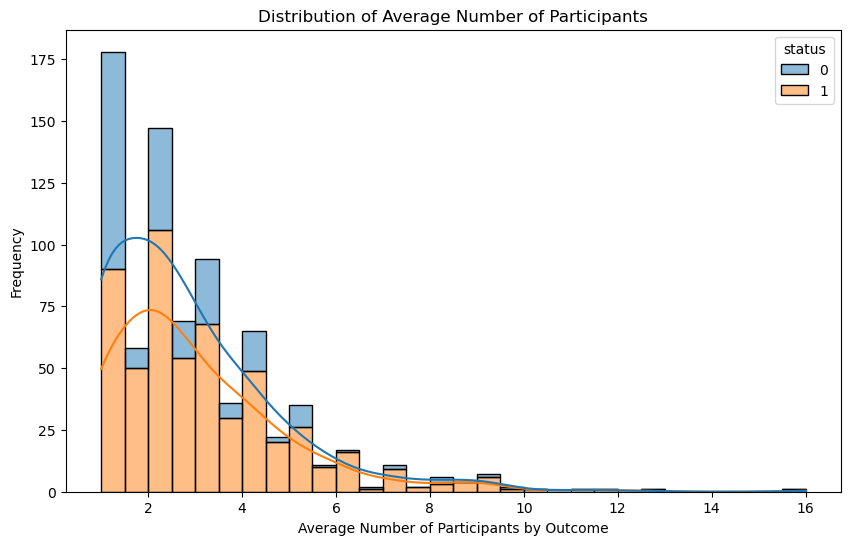

In [9]:
#Example for avg_participants
plt.figure(figsize=(10, 6))
sns.histplot(data=data_clean, x='avg_participants', hue = "status", multiple = "stack", bins=30, kde=True)
plt.title('Distribution of Average Number of Participants')
plt.xlabel('Average Number of Participants by Outcome')
plt.ylabel('Frequency')
plt.savefig("Average_Participants_by_Outcome")
plt.show()

### Understanding Distribution of Categorical Variables

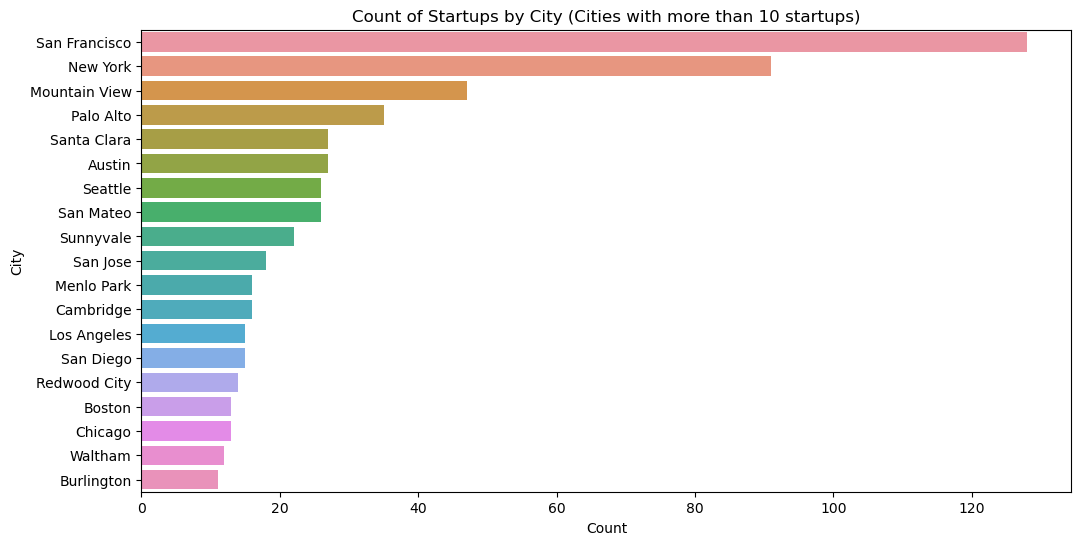

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' has a 'success' column indicating if a startup is successful (1) or not (0).
# First, calculate the city counts.
city_counts = data['city'].value_counts()

# Set the threshold for the minimum number of startups per city.
threshold = 10 

# Filter the cities based on the threshold.
filtered_cities = city_counts[city_counts > threshold].index

# Filter the data to include only those cities.
filtered_data = data[data['city'].isin(filtered_cities)]

# Plotting the count of successful startups by city.
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_data, y='city', order=filtered_data['city'].value_counts().index)
plt.title('Count of Startups by City (Cities with more than {} startups)'.format(threshold))
plt.xlabel('Count')
plt.ylabel('City')
plt.savefig("startups_by_city_general")
plt.show()

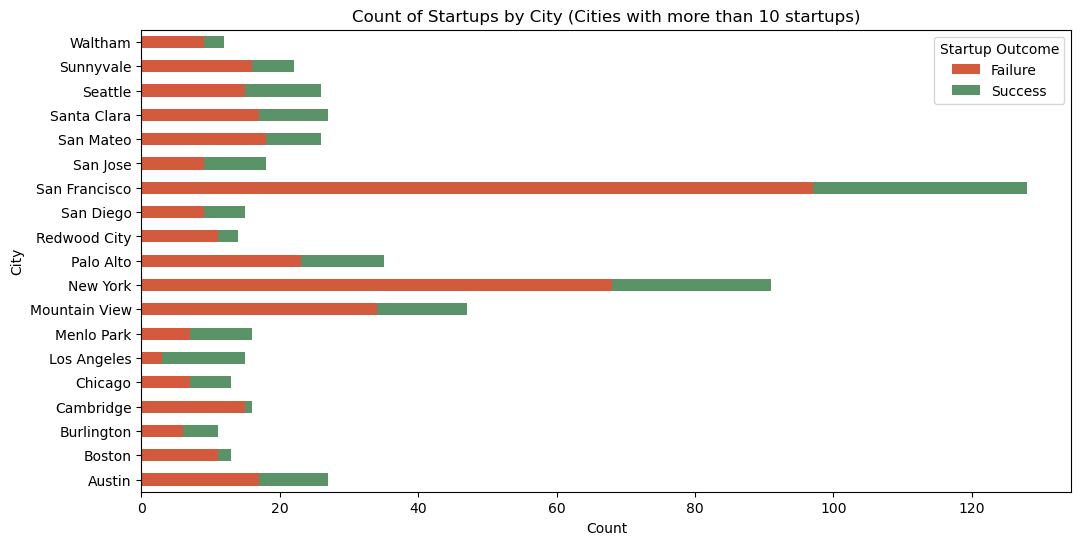

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'data' has a 'success' column indicating if a startup is successful (1) or not (0).
# Calculate the city counts.
city_counts = data['city'].value_counts()

# Set the threshold for the minimum number of startups per city.
threshold = 10 

# Filter the cities based on the threshold.
filtered_cities = city_counts[city_counts > threshold].index

# Filter the data to include only those cities.
filtered_data = data[data['city'].isin(filtered_cities)]

# Calculate the number of successful and unsuccessful startups per city.
city_success_counts = filtered_data.groupby(['city', 'status']).size().reset_index(name='count')

# Pivot this dataframe to have cities on the index, success status as columns, and counts as values.
city_success_pivot = city_success_counts.pivot(index='city', columns='status', values='count').fillna(0)

# Now create a stacked bar plot.
city_success_pivot.plot(kind='barh', stacked=True, figsize=(12, 6), color = ['#D45A3E', '#5A9367'])

plt.title('Count of Startups by City (Cities with more than {} startups)'.format(threshold))
plt.xlabel('Count')
plt.ylabel('City')
plt.legend(title='Startup Outcome', labels=['Failure', 'Success'])
plt.savefig("startups_by_city_rate")
plt.show()

###  Funding by City

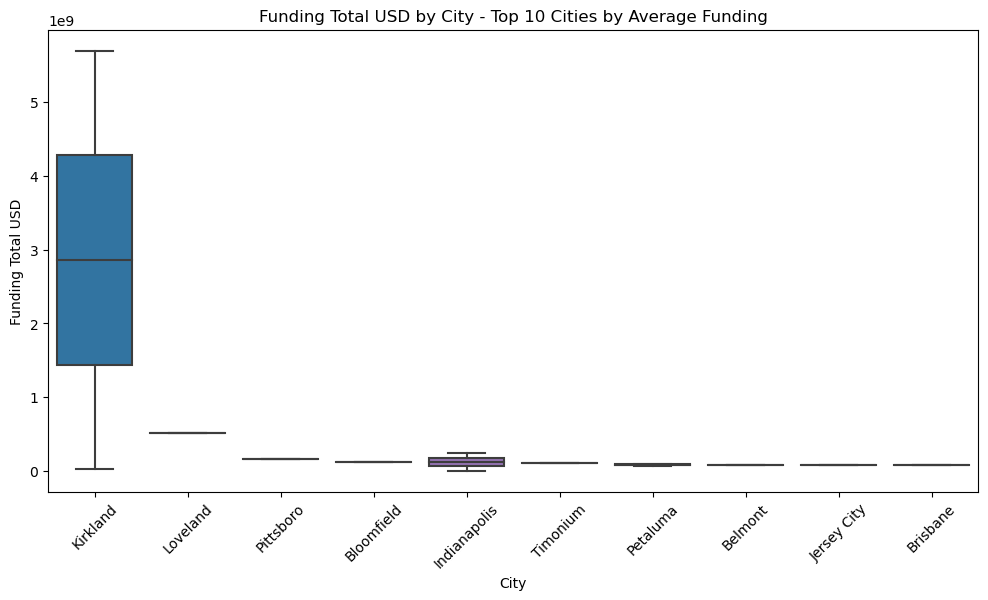

In [12]:
average_funding_by_city = data.groupby('city')['funding_total_usd'].mean()

# Determine the top N cities by average funding
N = 10  # Adjust this value based on your needs
top_cities_by_avg_funding = average_funding_by_city.nlargest(N).index

# Filter the DataFrame to include only these top cities
filtered_data = data[data['city'].isin(top_cities_by_avg_funding)]

# Plotting
plt.figure(figsize=(12, 6))
sns.boxplot(x='city', y='funding_total_usd', data=filtered_data, order=top_cities_by_avg_funding)
plt.title('Funding Total USD by City - Top {} Cities by Average Funding'.format(N))
plt.xticks(rotation=45)  # Rotate the x-labels for better readability
plt.xlabel('City')
plt.ylabel('Funding Total USD')
plt.savefig("funding_by_city")
plt.show()

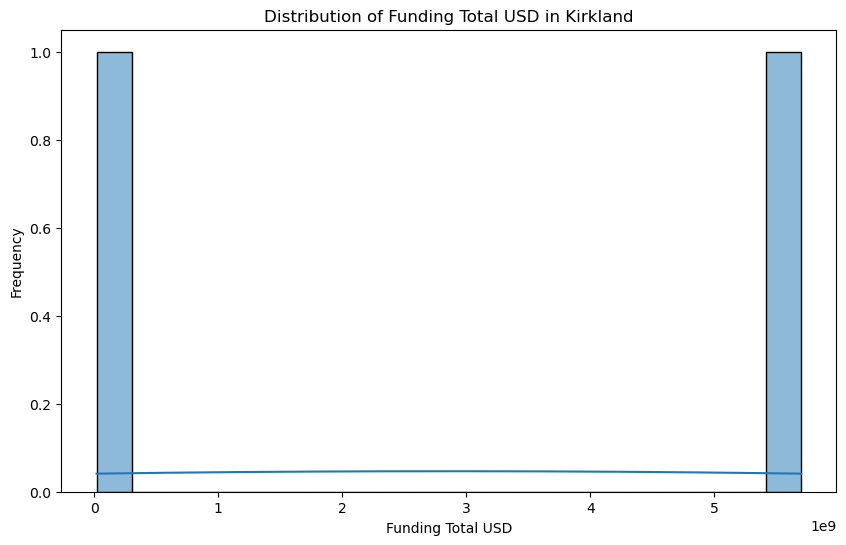

In [13]:
kirkland_data = data[data['city'] == 'Kirkland']

# Check if there are any entries for Kirkland
if not kirkland_data.empty:
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.histplot(kirkland_data['funding_total_usd'], bins=20, kde=True)
    plt.title('Distribution of Funding Total USD in Kirkland')
    plt.xlabel('Funding Total USD')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("No data available for Kirkland.")

In [14]:
#assess consistency in funding (avoiding outliers)
# TODO: Avg funding for successful and failure 
import pandas as pd

# Assuming df is your DataFrame

# Group data by city and calculate mean and standard deviation of funding
city_funding_stats = data.groupby('city')['funding_total_usd'].agg(['mean', 'std'])

# Calculate the coefficient of variation (std/mean)
# We handle division by zero by replacing infinities with NaN
city_funding_stats['cv'] = (city_funding_stats['std'] / city_funding_stats['mean']).replace([float('inf'), -float('inf')], pd.NA)

# Sort cities by coefficient of variation, lowest first (most consistent funding)
sorted_cities = city_funding_stats.sort_values(by='cv')

# Display the top cities with the most consistent funding
print(sorted_cities.head())


                    mean           std        cv
city                                            
Brisbane    7.800000e+07  7.071068e+06  0.090655
Acton       3.050000e+07  3.535534e+06  0.115919
Woburn      1.766667e+07  3.785939e+06  0.214298
Richardson  2.605500e+07  6.959030e+06  0.267090
Petaluma    8.038500e+07  2.515179e+07  0.312892


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Patch

# ... [your data manipulation code here] ...

# Define the custom color palette
custom_palette = ['#D45A3E', '#5A9367']

# Plotting
plt.figure(figsize=(12, 6))

# Create a bar plot with the custom palette
bar_plot = sns.barplot(x='city', y='funding_total_usd', hue='status', data=average_funding_by_city_success, 
            order=top_cities_by_avg_funding, palette=custom_palette)

plt.title('Average Funding Total USD by City for Successful and Failed Startups - Top {} Cities'.format(N))
plt.xticks(rotation=45)  # Rotate the x-labels for better readability
plt.xlabel('City')
plt.ylabel('Average Funding Total USD')

# Create custom legend
legend_patches = [Patch(color=custom_palette[i], label=status) for i, status in enumerate(average_funding_by_city_success['status'].unique())]
plt.legend(handles=legend_patches, title='Startup Outcome')
plt.savefig("average_funding_rate")
plt.show()

# Data Preparation

In [15]:
data_clean

,name,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,zip_code_98121,zip_code_98122,zip_code_98371,zip_code_98665,zip_code_99202,zip_code_CA 90245,zip_code_CA 94105,zip_code_Maryland 21045,amt_days_bw_found_first_fund,founding_month
0,Bandsintown,2.2493,3.0027,4.6685,6.7041,3,3,375000,3,1,...,0,0,0,0,0,0,0,0,821,1
1,TriCipher,5.1260,9.9973,7.0055,7.0055,9,4,40100000,1,1,...,0,0,0,0,0,0,0,0,1871,1
2,Plixi,1.0329,1.0329,1.4575,2.2055,5,1,2600000,2,1,...,0,0,0,0,0,0,0,0,377,3
3,Solidcore Systems,3.1315,5.3151,6.0027,6.0027,5,3,40000000,1,1,...,0,0,0,0,0,0,0,0,1143,1
4,Inhale Digital,0.0000,1.6685,0.0384,0.0384,2,2,1300000,1,1,...,0,0,0,0,0,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,CoTweet,0.5178,0.5178,0.5808,4.5260,9,1,1100000,2,1,...,0,0,0,0,0,0,0,0,189,1
919,Reef Point Systems,7.2521,9.2274,6.0027,6.0027,1,3,52000000,1,0,...,0,0,0,0,0,0,0,0,2647,1
920,Paracor Medical,8.4959,8.4959,9.0055,9.0055,5,1,44000000,1,1,...,0,0,0,0,0,0,0,0,3101,1
921,Causata,0.7589,2.8329,0.7589,3.8356,12,2,15500000,2,1,...,0,0,0,0,0,0,0,0,277,1


In [16]:
def prepare_balanced_data_for_modeling(data, target_column='status', test_size=0.2, random_state=42):
    # Separate rows with 'status' equal to 0 and 1
    status_0_data = data[data[target_column] == 0]
    status_1_data = data[data[target_column] == 1]

    # Randomly select a balanced number of rows from each class
    min_samples = min(len(status_0_data), len(status_1_data))
    balanced_data = pd.concat([
        status_0_data.sample(min_samples, random_state=random_state),
        status_1_data.sample(min_samples, random_state=random_state)
    ])

    # Drop columns that are not features
    features = balanced_data.drop(columns=[target_column, 'name', 'founding_month'])

    # Separate features (X) and target (y)
    X = features.copy()
    y = balanced_data[target_column]

    # Split the dataset into training and testing sets with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Concatenate the remaining rows from data_clean that were not used in the testing set
    #unused_data = data_clean[~data_clean.index.isin(X_train.index)]
    #unused_data = unused_data[~unused_data.index.isin(X_test.index)]
    #X_test = pd.concat([X_test, unused_data.drop(columns=[target_column, 'name', 'founding_month'])])
    #y_test = pd.concat([y_test, unused_data[target_column]])

    # Display class distribution in train and test sets
    print("Training set class distribution:")
    print(y_train.value_counts(normalize=True))  # Normalized value counts for y_train
    print("\nTesting set class distribution:")
    print(y_test.value_counts(normalize=True))  # Normalized value counts for y_test
    return X_train, X_test, y_train, y_test

# Call the function with your data
X_train, X_test, y_train, y_test = prepare_balanced_data_for_modeling(data_clean.copy())

Training set class distribution:
1    0.501416
0    0.498584
Name: status, dtype: float64

Testing set class distribution:
0    0.505618
1    0.494382
Name: status, dtype: float64


In [17]:
X_train.shape

(353, 635)

In [18]:
X_test.shape

(89, 635)

In [19]:
data_clean[data_clean['status'] == 1].copy()

,name,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,zip_code_98121,zip_code_98122,zip_code_98371,zip_code_98665,zip_code_99202,zip_code_CA 90245,zip_code_CA 94105,zip_code_Maryland 21045,amt_days_bw_found_first_fund,founding_month
0,Bandsintown,2.2493,3.0027,4.6685,6.7041,3,3,375000,3,1,...,0,0,0,0,0,0,0,0,821,1
1,TriCipher,5.1260,9.9973,7.0055,7.0055,9,4,40100000,1,1,...,0,0,0,0,0,0,0,0,1871,1
2,Plixi,1.0329,1.0329,1.4575,2.2055,5,1,2600000,2,1,...,0,0,0,0,0,0,0,0,377,3
3,Solidcore Systems,3.1315,5.3151,6.0027,6.0027,5,3,40000000,1,1,...,0,0,0,0,0,0,0,0,1143,1
6,RingCube Technologies,1.7205,5.2110,3.0000,6.6082,6,3,26000000,2,1,...,0,0,0,0,0,0,0,0,628,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,TRAFFIQ,0.0000,3.9288,2.9151,5.7342,16,3,18000000,3,0,...,0,0,0,0,0,0,0,0,0,9
917,Dexterra,5.6301,8.7589,8.5041,8.7589,9,5,122500000,2,0,...,0,0,0,0,0,0,0,0,2055,1
918,CoTweet,0.5178,0.5178,0.5808,4.5260,9,1,1100000,2,1,...,0,0,0,0,0,0,0,0,189,1
921,Causata,0.7589,2.8329,0.7589,3.8356,12,2,15500000,2,1,...,0,0,0,0,0,0,0,0,277,1


In [20]:
data_clean.shape

(771, 638)

# Generate 5 sets of training and validation data for cross validation testing

In [21]:
def get_datasets_for_cross_validation(data_clean):
    np.random.seed(12)

    success_X_y = data_clean[data_clean['status'] == 1].copy()
    fail_X_y = data_clean[data_clean['status'] == 0].copy()

    success_X_y = success_X_y.sample(frac=1).reset_index(drop=True)
    fail_X_y = fail_X_y.sample(frac=1).reset_index(drop=True)

    num_parts = 5
    success_parts = np.array_split(success_X_y, num_parts)
    fail_parts = np.array_split(fail_X_y, num_parts)

    set1 = pd.concat([success_parts[0], fail_parts[0]], axis=0, ignore_index=True)
    set2 = pd.concat([success_parts[1], fail_parts[1]], axis=0, ignore_index=True)
    set3 = pd.concat([success_parts[2], fail_parts[2]], axis=0, ignore_index=True)
    set4 = pd.concat([success_parts[3], fail_parts[3]], axis=0, ignore_index=True)
    set5 = pd.concat([success_parts[4], fail_parts[4]], axis=0, ignore_index=True)

    #getting first X_train, y_train, X_val, y_val
    train_1 = pd.concat([set1, set2, set3, set4], axis = 0,ignore_index=True)
    val_1 = set5
    y_train_1 = train_1['status']
    y_val_1 = val_1['status']
    train_1 = train_1.drop(['status'], axis = 1)
    val_1 = val_1.drop(['status'], axis = 1)

    #getting second X_train, y_train, X_val, y_val
    train_2 = pd.concat([set1, set2, set3, set5], axis = 0,ignore_index=True)
    val_2 = set4
    y_train_2 = train_2['status']
    y_val_2 = val_2['status']
    train_2 = train_2.drop(['status'], axis = 1)
    val_2 = val_2.drop(['status'], axis = 1)

    #getting third X_train, y_train, X_val, y_val
    train_3 = pd.concat([set1, set2, set4, set5], axis = 0,ignore_index=True)
    val_3 = set3
    y_train_3 = train_3['status']
    y_val_3 = val_3['status']
    train_3 = train_3.drop(['status'], axis = 1)
    val_3 = val_3.drop(['status'], axis = 1)

    #getting fourth X_train, y_train, X_val, y_val
    train_4 = pd.concat([set1, set3, set4, set5], axis = 0,ignore_index=True)
    val_4 = set2
    y_train_4 = train_4['status']
    y_val_4 = val_4['status']
    train_4 = train_4.drop(['status'], axis = 1)
    val_4 = val_4.drop(['status'], axis = 1)

    #getting fifth X_train, y_train, X_val, y_val
    train_5 = pd.concat([set2, set3, set4, set5], axis = 0,ignore_index=True)
    val_5 = set1
    y_train_5 = train_5['status']
    y_val_5 = val_5['status']
    train_5 = train_5.drop(['status'], axis = 1)
    val_5 = val_5.drop(['status'], axis = 1)

    X_training_sets = [train_1, train_2, train_3, train_4, train_5]
    X_validation_sets = [val_1, val_2, val_3, val_4, val_5]
    y_train_sets = [y_train_1, y_train_2, y_train_3, y_train_4, y_train_5]
    y_valid_sets = [y_val_1, y_val_2, y_val_3, y_val_4, y_val_5]

    return X_training_sets, X_validation_sets, y_train_sets,y_valid_sets

# Methods

## 1. Sparse Logistic Regression

In [22]:
def sparse_regression_classifier(X_train, y_train, X_test, y_test, penalty='l1', solver='liblinear', random_state=42):
    
    # Initialize and fit the Lasso Logistic Regression model
    lasso_model = LogisticRegression(penalty=penalty, solver=solver, random_state=random_state)
    lasso_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = lasso_model.predict(X_test)

    # Extract features with non-zero coefficients
    selected_features = X_train.columns[(lasso_model.coef_ != 0).flatten()]
    coefficients = lasso_model.coef_[0][(lasso_model.coef_ != 0).flatten()]

    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'Feature': selected_features,
        'Coefficient': coefficients
    })

    # Filter columns to keep based on the model's feature importance
    all_features = list(summary_df['Feature'])
    columns_to_keep_lasso = [
        col for col in all_features if not col.startswith('city_') and not col.startswith('zip_code_')
    ]

    # Create reduced train and test sets based on selected features
    X_train_reduced = X_train[columns_to_keep_lasso]
    X_test_reduced = X_test[columns_to_keep_lasso]

    # Print Lasso selected features and their coefficients
    print("Lasso Selected Features and Coefficients:")
    print(summary_df)

    # Calculate accuracy and other metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of the Lasso model on the test set: {accuracy:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Number of features selected by Lasso
    print(f"Original number of features: {X_train.shape[1]}")
    print(f"Number of features selected by Lasso: {summary_df.shape[0]}")

    # Top features by absolute coefficient value
    top_features = summary_df.sort_values(by='Coefficient', key=abs, ascending=False).head(10)
    print("Top 10 features by absolute coefficient value:")
    print(top_features)

    # Features not selected by Lasso
    non_selected_features = set(X_train.columns) - set(summary_df['Feature'])
    print(f"Features not selected by Lasso: {non_selected_features}")

    return lasso_model, summary_df, X_train_reduced, X_test_reduced, columns_to_keep_lasso

# Call the function with your data
lasso_model, summary_df, X_train_reduced, X_test_reduced, columns_to_keep_lasso = sparse_regression_classifier(X_train, y_train, X_test, y_test)

Lasso Selected Features and Coefficients:
                         Feature   Coefficient
0          age_last_funding_year  9.135598e-02
1       age_first_milestone_year -2.237447e-02
2        age_last_milestone_year  2.298439e-01
3                  relationships  1.238694e-01
4              funding_total_usd -4.504385e-09
5                     milestones -2.192910e-01
6                          is_TX -4.801818e-01
7                  is_otherstate -5.288724e-01
8                    is_software  3.193431e-01
9                         is_web  1.919783e-01
10                 is_enterprise -2.461863e-02
11                is_advertising -6.357944e-04
12                 is_gamesvideo -6.895177e-01
13                  is_ecommerce -3.905599e-01
14                        has_VC -5.910258e-01
15                     has_angel -1.395455e-02
16                    has_roundA -1.841974e-01
17                    has_roundB  3.825833e-02
18                    has_roundD  6.085310e-02
19              av

In [23]:
columns_to_keep_lasso.extend(['status'])
columns_to_keep_lasso

['age_last_funding_year',
 'age_first_milestone_year',
 'age_last_milestone_year',
 'relationships',
 'funding_total_usd',
 'milestones',
 'is_TX',
 'is_otherstate',
 'is_software',
 'is_web',
 'is_enterprise',
 'is_advertising',
 'is_gamesvideo',
 'is_ecommerce',
 'has_VC',
 'has_angel',
 'has_roundA',
 'has_roundB',
 'has_roundD',
 'avg_participants',
 'is_top500',
 'amt_days_bw_found_first_fund',
 'status']

In [24]:
cv_data = data_clean.drop(columns=['founding_month', 'name'])
X_training_sets, X_test_sets, y_train_sets, y_test_sets = get_datasets_for_cross_validation(cv_data)
reduced_data = data_clean[columns_to_keep_lasso].copy()
Xr_training_sets, Xr_test_sets, yr_train_sets, yr_test_sets = get_datasets_for_cross_validation(reduced_data)

## 2. XGBoost

In [26]:
def xgb_classifier(X_train, y_train, X_test, y_test, X_training_sets, X_test_sets, y_train_sets, y_test_sets, use_proba=True, cv_folds=5):
    
    # Initialize the XGBoost classifier
    xgb_classifier = xgb.XGBClassifier(random_state=42)

    # Define the parameter grid
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        # Add other parameters here
    }

    # GridSearchCV
    grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, 
                               cv=cv_folds, scoring='accuracy', verbose=1)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator
    best_xgb_classifier = grid_search.best_estimator_

    # Make predictions
    y_pred = best_xgb_classifier.predict(X_test)

    # Calculate the probabilities for ROC and Precision-Recall
    y_pred_proba = best_xgb_classifier.predict_proba(X_test)[:, 1]

    # Model Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    
    # Classification Report
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)
    
    # Calculate and plot ROC Curve and AUC 
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print("ROC AUC Score:", roc_auc)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right")
    plt.show()
    
    # Plot feature importance
    xgb.plot_importance(best_xgb_classifier)
    plt.show()
    feature_importances = best_xgb_classifier.feature_importances_
    top_features = sorted(zip(X_train.columns, feature_importances), key=lambda x: x[1], reverse=True)[:3]
    top_features_info = {f"Feature {i+1}": f"{feature[0]} ({feature[1]:.3f})" for i, feature in enumerate(top_features)}

    # Cross-Validation Scores
    best_params = best_xgb_classifier.get_params()
    num_parts = len(X_training_sets)
    cross_acc_scores = []
    cross_auc_scores = []
    cross_precision_scores = []
    cross_precision_scores_0 = []
    for i in range(num_parts):
        new_xgb_model = xgb.XGBClassifier(**best_params)
        new_xgb_model.fit(X_training_sets[i], y_train_sets[i])
        
        cv_y_pred = new_xgb_model.predict(X_test_sets[i])
        cv_y_pred = (cv_y_pred >= 0.4).astype(int)
        cv_accuracy = accuracy_score(y_test_sets[i], cv_y_pred)
        cross_acc_scores.append(cv_accuracy)
        
        cv_y_pred_proba = best_xgb_classifier.predict_proba(X_test_sets[i])[:, 1]
        cv_roc_auc = roc_auc_score(y_test_sets[i], cv_y_pred_proba)
        cross_auc_scores.append(cv_roc_auc)
        
        cv_precision = precision_score(y_test_sets[i], cv_y_pred)
        cross_precision_scores.append(cv_precision)
        
        precision_for_class_0 = precision_score(y_test_sets[i], cv_y_pred, pos_label=0)
        cross_precision_scores_0.append(precision_for_class_0)
        
    
    mean_cv_accuracy = sum(cross_acc_scores) / len(cross_acc_scores)
    mean_cv_auc = sum(cross_auc_scores)/len(cross_auc_scores)
    mean_cv_precision = sum(cross_precision_scores)/len(cross_precision_scores)
    mean_cv_precision_0 = sum(cross_precision_scores_0)/len(cross_precision_scores)
    print("Mean CV Accuracy:", mean_cv_accuracy)
    print("Mean CV AUC:", mean_cv_auc)
    print("Mean CV Precision:", mean_cv_precision)
    print("Mean CV Precision 0 :", mean_cv_precision_0)
    
    results = {
        'Accuracy': accuracy,
        'Confusion Matrix': cm,
        'Classification Report': report,
        'ROC AUC Score': roc_auc,
        'Mean CV Accuracy': mean_cv_accuracy,
        'Mean CV AUC': mean_cv_auc,
        'Mean CV Precision': mean_cv_precision,
        'Mean CV Precision 0': mean_cv_precision_0,
        'Top 3 Features': top_features_info
    }

    return results

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Accuracy: 0.5730337078651685
Confusion Matrix:
 [[22 23]
 [15 29]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.49      0.54        45
           1       0.56      0.66      0.60        44

    accuracy                           0.57        89
   macro avg       0.58      0.57      0.57        89
weighted avg       0.58      0.57      0.57        89

ROC AUC Score: 0.6553030303030303


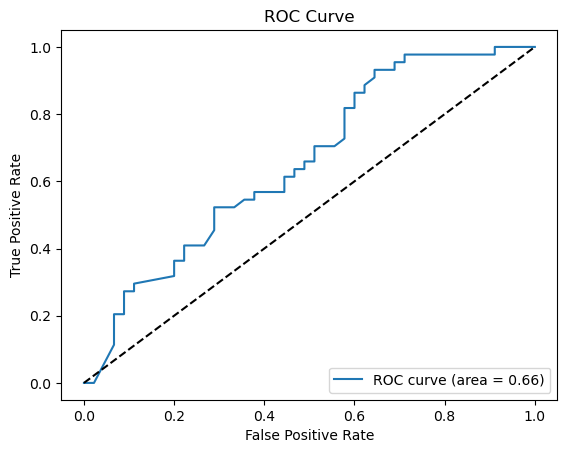

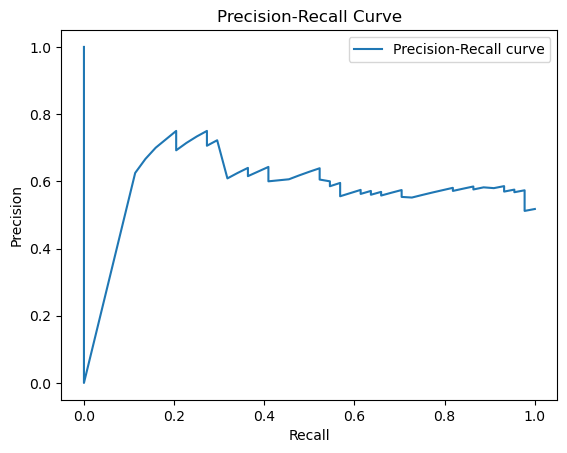

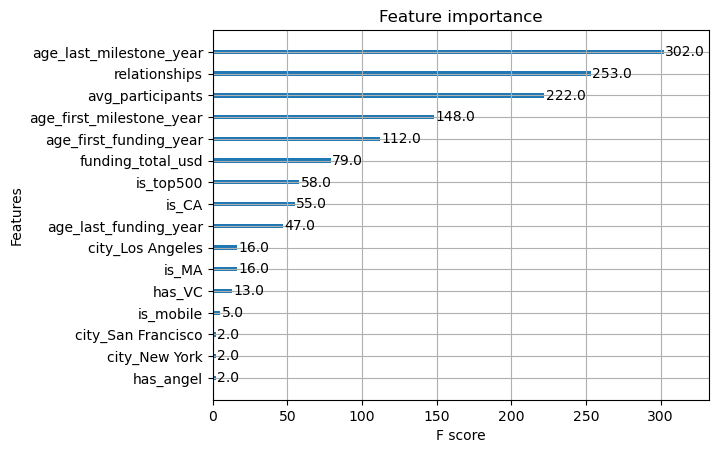

Mean CV Accuracy: 0.7730959363217429
Mean CV AUC: 0.842674012855831
Mean CV Precision: 0.780480927864376
Mean CV Precision 0 : 0.7443633661024965


In [27]:
complete_XGB=xgb_classifier(X_train, y_train, X_test, y_test, X_training_sets, X_test_sets, y_train_sets, y_test_sets)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Accuracy: 0.5730337078651685
Confusion Matrix:
 [[22 23]
 [15 29]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.49      0.54        45
           1       0.56      0.66      0.60        44

    accuracy                           0.57        89
   macro avg       0.58      0.57      0.57        89
weighted avg       0.58      0.57      0.57        89

ROC AUC Score: 0.6575757575757576


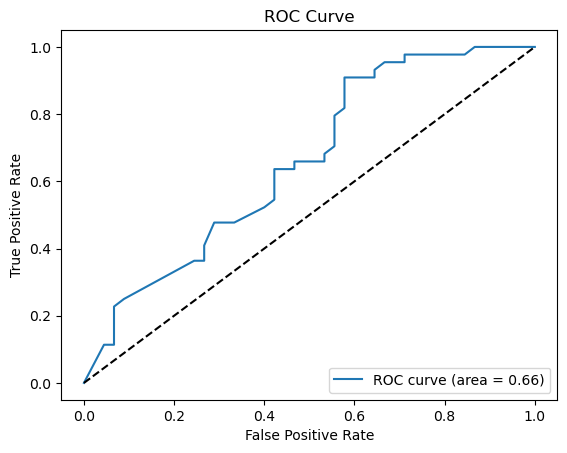

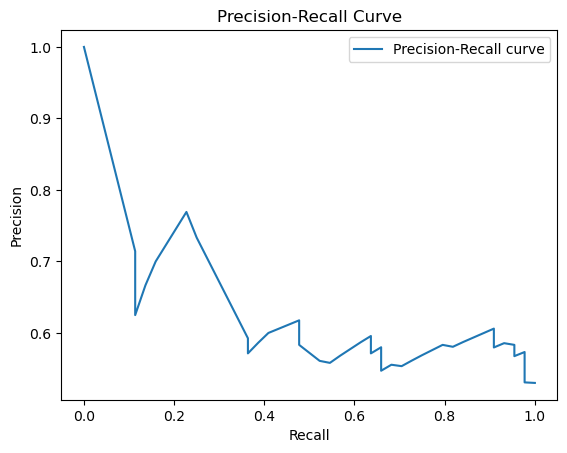

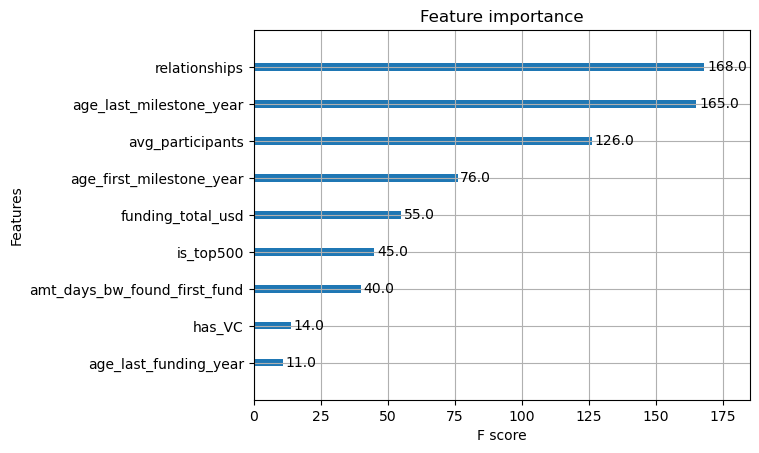

Mean CV Accuracy: 0.7601256807708421
Mean CV AUC: 0.8173833792470155
Mean CV Precision: 0.761896330711188
Mean CV Precision 0 : 0.7844444444444445


In [28]:
reduced_XGB = xgb_classifier(X_train_reduced, y_train, X_test_reduced, y_test, Xr_training_sets, Xr_test_sets, yr_train_sets, yr_test_sets)

## 3. CART

In [33]:
def CART_classifier(X_train, y_train, X_test, y_test):
    np.random.seed(12)
    # Create Decision Tree classifier object
    clf = DecisionTreeClassifier()

    # Define the parameter grid
    param_grid = {
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        # Add other parameters here
    }

    # GridSearchCV
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
                               cv=5, scoring='accuracy', verbose=1)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator
    best_clf = grid_search.best_estimator_

    # Predict the response for the test dataset
    y_pred = best_clf.predict(X_test)
    
    # Plot Decision Tree
    plt.figure(figsize=(20,10))
    plot_tree(best_clf, filled=True)
    plt.show()

    # Model Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    
    # Classification Report
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)
    
    # ROC-AUC 
    y_pred_prob = best_clf.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print("ROC AUC Score:", roc_auc)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # Feature Importances
    feature_importances = best_clf.feature_importances_
    top_features = sorted(zip(X_train.columns, feature_importances), key=lambda x: x[1], reverse=True)[:3]
    top_features_info = {f"Feature {i+1}": f"{feature[0]} ({feature[1]:.3f})" for i, feature in enumerate(top_features)}
    indices = np.argsort(feature_importances)[-10:]  # Get the indices of the top features
    plt.figure(figsize=(10,10))
    plt.title('Top 10 Feature Importances'.format(10))
    plt.barh(range(len(indices)), feature_importances[indices], color='lightblue', align='center')
    plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

    # Cross-Validation Scores
    best_params = best_clf.get_params()
    
    num_parts = len(X_training_sets)
    cross_acc_scores = []
    cross_auc_scores = []
    cross_precision_scores = []
    cross_precision_scores_0 = []
    for i in range(num_parts):
        new_tree_clf = DecisionTreeClassifier(**best_params)
        new_tree_clf.fit(X_training_sets[i], y_train_sets[i])
        
        cv_y_pred = new_tree_clf.predict(X_test_sets[i])
        cv_y_pred = (cv_y_pred >= 0.6).astype(int)
        cv_accuracy = accuracy_score(y_test_sets[i], cv_y_pred)
        cross_acc_scores.append(cv_accuracy)
        
        cv_y_pred_proba = new_tree_clf.predict_proba(X_test_sets[i])[:, 1]
        cv_roc_auc = roc_auc_score(y_test_sets[i], cv_y_pred_proba)
        cross_auc_scores.append(cv_roc_auc)
        
        cv_precision = precision_score(y_test_sets[i], cv_y_pred)
        cross_precision_scores.append(cv_precision)
        
        precision_for_class_0 = precision_score(y_test_sets[i], cv_y_pred, pos_label=0)
        cross_precision_scores_0.append(precision_for_class_0)
    
    mean_cv_accuracy = sum(cross_acc_scores) / len(cross_acc_scores)
    mean_cv_auc = sum(cross_auc_scores)/len(cross_auc_scores)
    mean_cv_precision = sum(cross_precision_scores)/len(cross_precision_scores)
    mean_cv_precision_0 = sum(cross_precision_scores_0)/len(cross_precision_scores_0)
    print("Mean CV Accuracy:", mean_cv_accuracy)
    print("Mean CV AUC:", mean_cv_auc)
    print("Mean CV Precision:", mean_cv_precision)
    print("Mean CV Precision 0:", mean_cv_precision_0)
    
    results = {
        'Accuracy': accuracy,
        'Confusion Matrix': cm,
        'Classification Report': report,
        'ROC AUC Score': roc_auc,
        'Mean CV Accuracy': mean_cv_accuracy,
        'Mean CV AUC': mean_cv_auc,
        'Mean CV Precision': mean_cv_precision, 
        'Mean CV Precision': mean_cv_precision_0,
        'Top 3 Features': top_features_info
    }
    
    return results

Fitting 5 folds for each of 54 candidates, totalling 270 fits


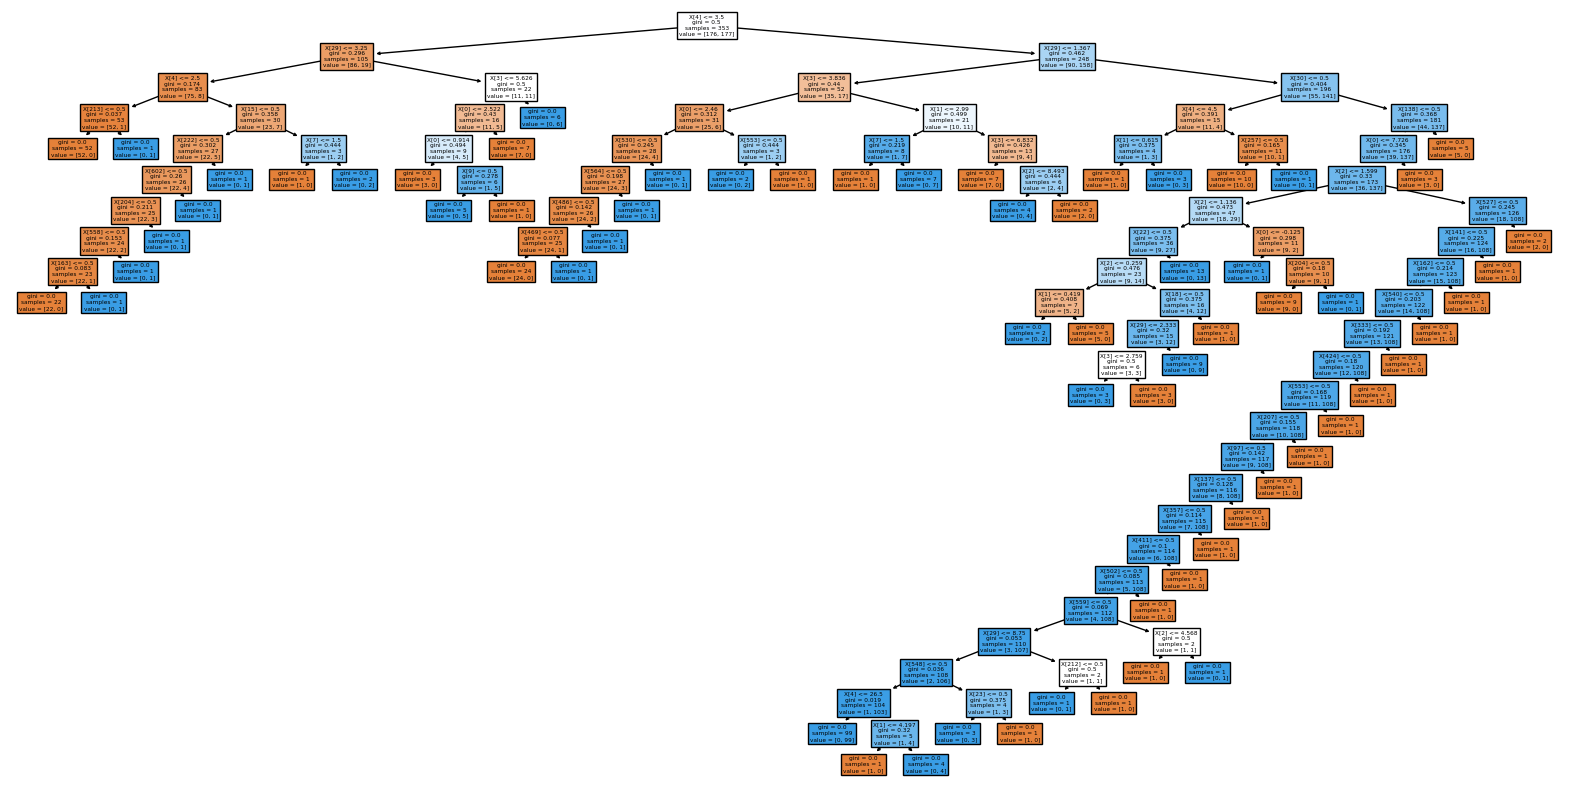

Accuracy: 0.5730337078651685
Confusion Matrix:
 [[28 17]
 [21 23]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.62      0.60        45
           1       0.57      0.52      0.55        44

    accuracy                           0.57        89
   macro avg       0.57      0.57      0.57        89
weighted avg       0.57      0.57      0.57        89

ROC AUC Score: 0.5724747474747475


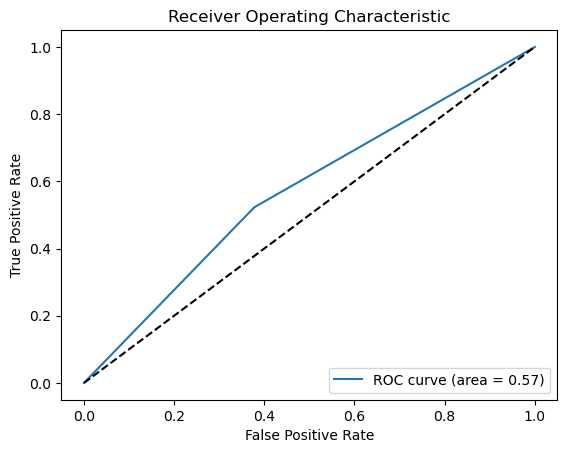

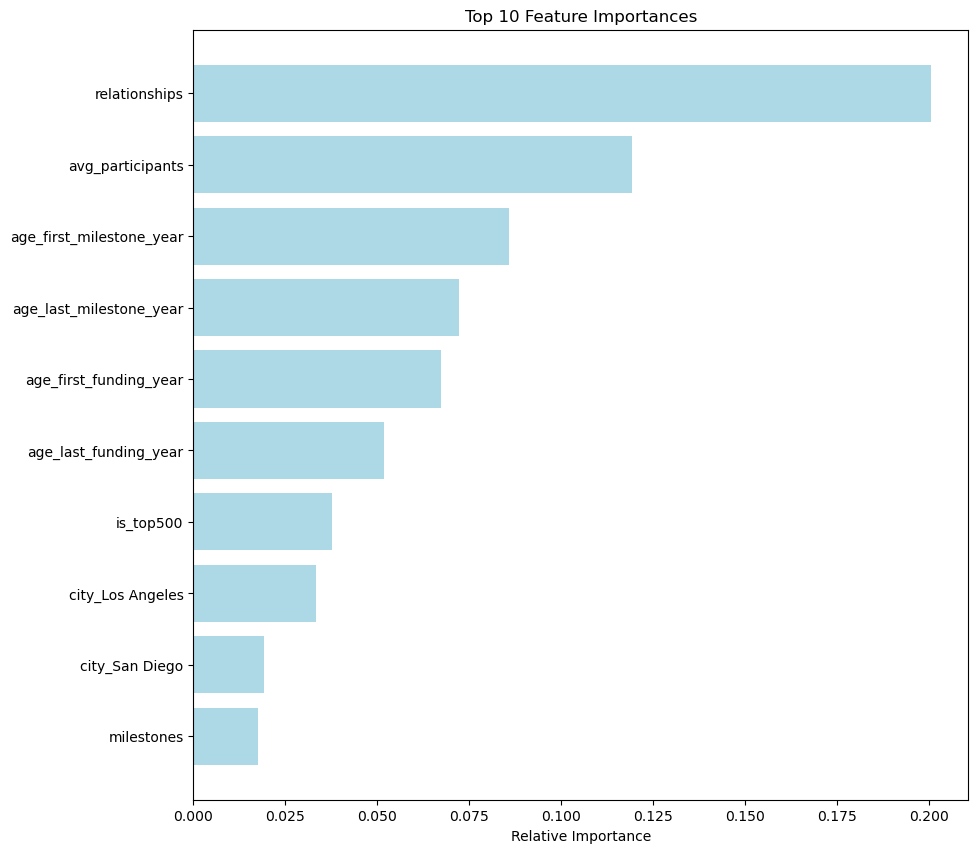

Mean CV Accuracy: 0.7419019689987432
Mean CV AUC: 0.6698181818181819
Mean CV Precision: 0.8152327027330072
Mean CV Precision 0: 0.5575079365079365


In [34]:
complete_CART=CART_classifier(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


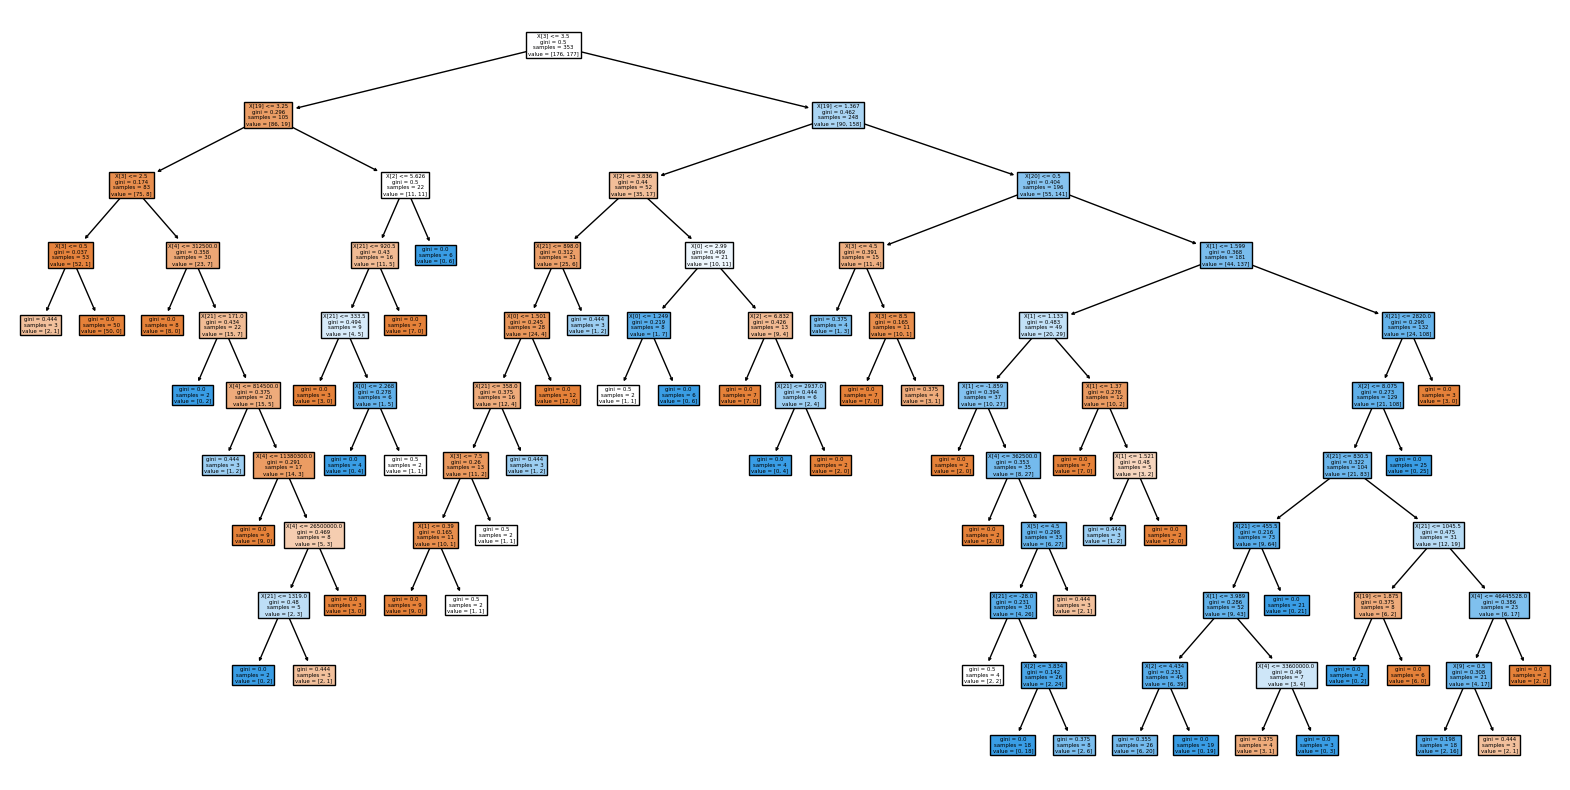

Accuracy: 0.6404494382022472
Confusion Matrix:
 [[28 17]
 [15 29]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.62      0.64        45
           1       0.63      0.66      0.64        44

    accuracy                           0.64        89
   macro avg       0.64      0.64      0.64        89
weighted avg       0.64      0.64      0.64        89

ROC AUC Score: 0.6537878787878788


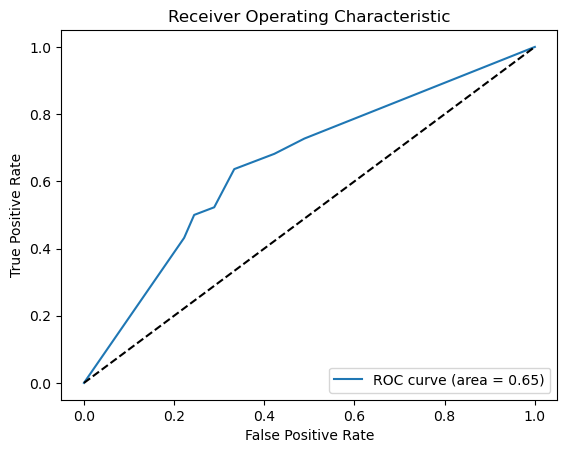

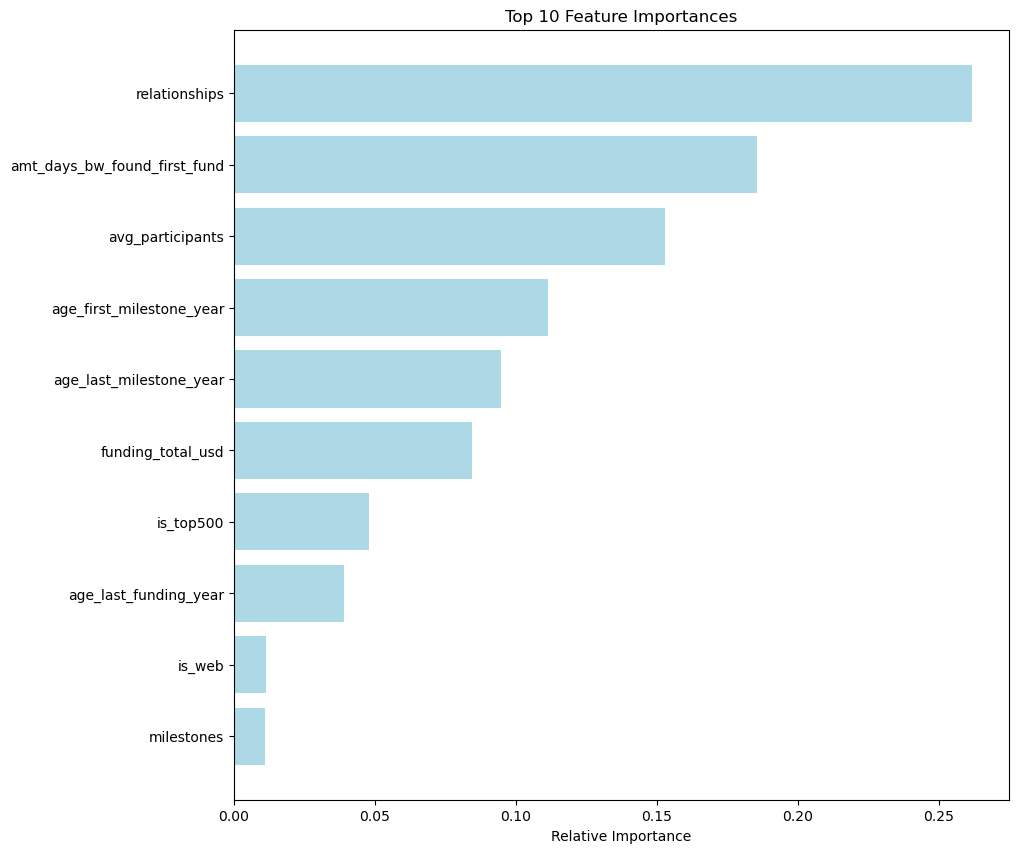

Mean CV Accuracy: 0.7743695014662756
Mean CV AUC: 0.7019054178145087
Mean CV Precision: 0.8207481790240412
Mean CV Precision 0: 0.6373169330321033


In [35]:
reduced_CART=CART_classifier(X_train_reduced, y_train, X_test_reduced, y_test)

## 4. Random Forest

In [36]:
def rf_classifier(X_train, y_train, X_test, y_test):
    np.random.seed(12)
    # Define the parameter grid for Random Forest
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 4, 6, 8, 10]
    }
    
    # Initialize and perform grid search to find the best parameters
    grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator from grid search
    best_rf_classifier = grid_search.best_estimator_
    
    # Make predictions on the test set
    y_pred = best_rf_classifier.predict(X_test)

    # Compute and print model accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    
    # Generate and print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    
    # Print classification report
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)
    
    # Compute ROC-AUC
    y_pred_prob = best_rf_classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print("ROC AUC Score:", roc_auc)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - Random Forest')
    plt.legend(loc="lower right")
    plt.show()
    
    # Visualize feature importances
    feature_importances = best_rf_classifier.feature_importances_
    top_features = sorted(zip(X_train.columns, feature_importances), key=lambda x: x[1], reverse=True)[:3]
    top_features_info = {f"Feature {i+1}": f"{feature[0]} ({feature[1]:.3f})" for i, feature in enumerate(top_features)}
    indices = np.argsort(feature_importances)[-10:]  # Top 10 features
    plt.figure(figsize=(10,10))
    plt.title('Top 10 Feature Importances in Random Forest Model')
    plt.barh(range(len(indices)), feature_importances[indices], color='lightblue', align='center')
    plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
    best_params = best_rf_classifier.get_params()
    
    num_parts = len(X_training_sets)
    cross_acc_scores = []
    cross_auc_scores = []
    cross_precision_scores = []
    cross_precision_scores_0 = []
    for i in range(num_parts):
        new_rf_clf = RandomForestClassifier(**best_params)
        new_rf_clf.fit(X_training_sets[i], y_train_sets[i])
        
        cv_y_pred = new_rf_clf.predict(X_test_sets[i])
        cv_y_pred = (cv_y_pred >= 0.4).astype(int)
        cv_accuracy = accuracy_score(y_test_sets[i], cv_y_pred)
        cross_acc_scores.append(cv_accuracy)
        
        cv_y_pred_proba = new_rf_clf.predict_proba(X_test_sets[i])[:, 1]
        cv_roc_auc = roc_auc_score(y_test_sets[i], cv_y_pred_proba)
        cross_auc_scores.append(cv_roc_auc)
        
        cv_precision = precision_score(y_test_sets[i], cv_y_pred)
        cross_precision_scores.append(cv_precision)
        
        precision_for_class_0 = precision_score(y_test_sets[i], cv_y_pred, pos_label=0)
        cross_precision_scores_0.append(precision_for_class_0)
        
    mean_cv_accuracy = sum(cross_acc_scores) / len(cross_acc_scores)
    mean_cv_auc = sum(cross_auc_scores)/len(cross_auc_scores)
    mean_cv_precision  = sum(cross_precision_scores)/len(cross_precision_scores)
    mean_cv_precision_0 = sum(cross_precision_scores_0)/len(cross_precision_scores_0)
    print("Mean CV Accuracy:", mean_cv_accuracy)
    print("Mean CV AUC:", mean_cv_auc)
    print("Mean CV Precision:", mean_cv_precision)
    print("Mean CV Precision 0 :", mean_cv_precision_0)

    results = {
        'Accuracy': accuracy,
        'Confusion Matrix': cm,
        'Classification Report': report,
        'ROC AUC Score': roc_auc,
        'Mean CV Accuracy': mean_cv_accuracy,
        'Mean CV AUC': mean_cv_auc, 
        'Mean CV Precision': mean_cv_precision,
        'Mean CV Precision 0': mean_cv_precision_0,
        'Top 3 Features': top_features_info
    }
    
    return results

Accuracy: 0.6853932584269663
Confusion Matrix:
 [[29 16]
 [12 32]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.64      0.67        45
           1       0.67      0.73      0.70        44

    accuracy                           0.69        89
   macro avg       0.69      0.69      0.69        89
weighted avg       0.69      0.69      0.68        89

ROC AUC Score: 0.6972222222222222


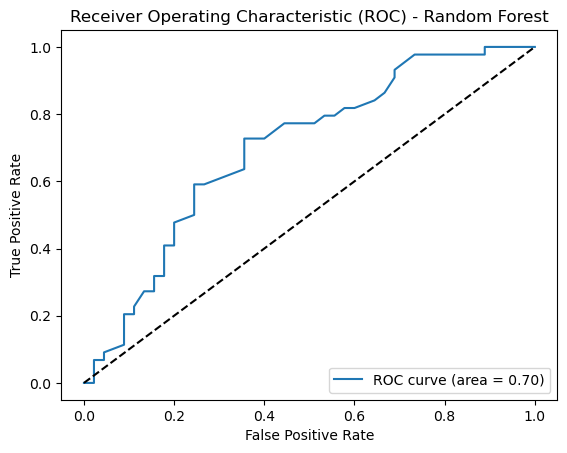

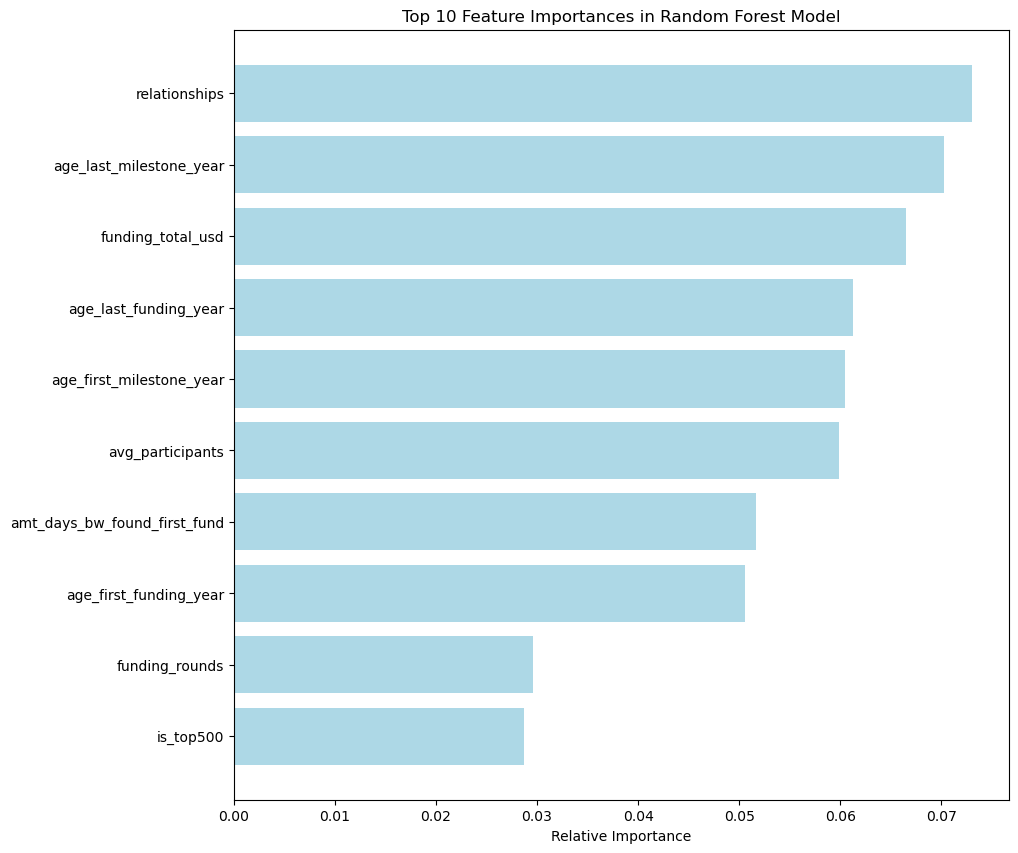

Mean CV Accuracy: 0.7847423544197738
Mean CV AUC: 0.749222681359045
Mean CV Precision: 0.7881808623780981
Mean CV Precision 0 : 0.7764585655890003


In [37]:
complete_rf=rf_classifier(X_train, y_train, X_test, y_test)

Accuracy: 0.6292134831460674
Confusion Matrix:
 [[26 19]
 [14 30]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.58      0.61        45
           1       0.61      0.68      0.65        44

    accuracy                           0.63        89
   macro avg       0.63      0.63      0.63        89
weighted avg       0.63      0.63      0.63        89

ROC AUC Score: 0.6909090909090909


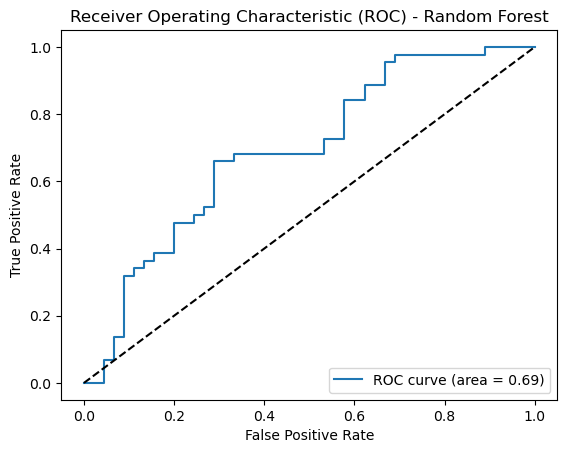

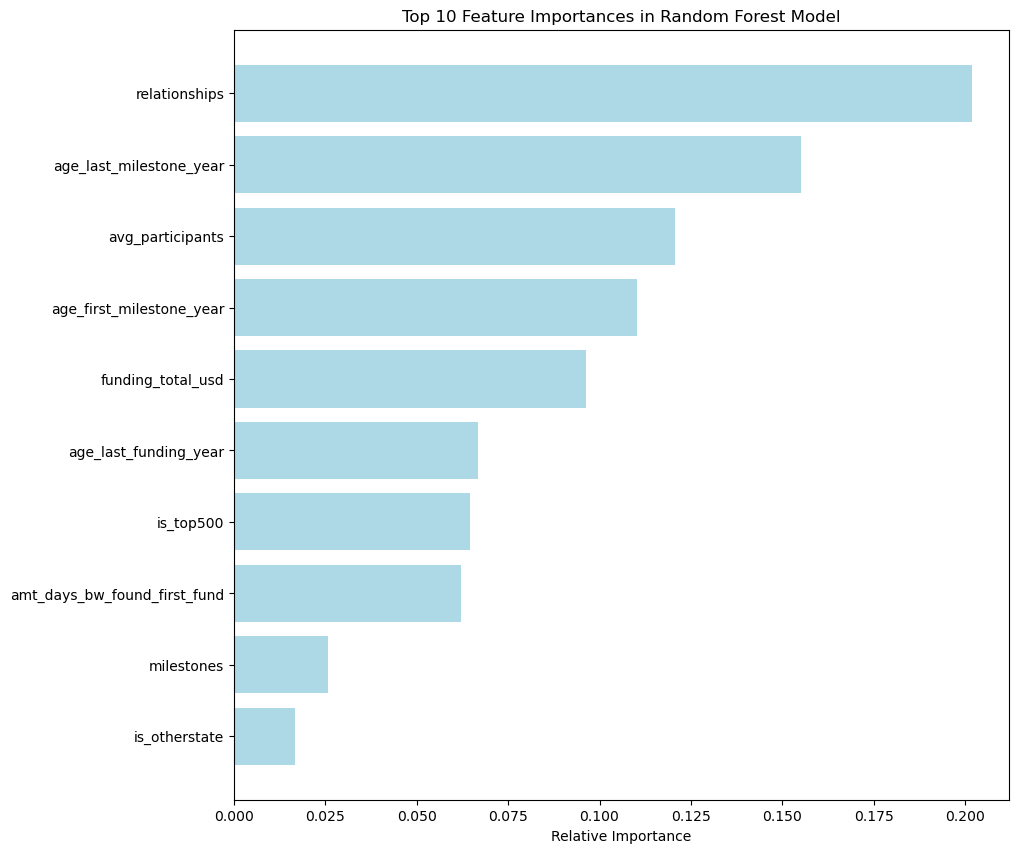

Mean CV Accuracy: 0.7574528697109343
Mean CV AUC: 0.7658732782369146
Mean CV Precision: 0.7477221402463393
Mean CV Precision 0 : 0.9568181818181818


In [38]:
reduced_rf=rf_classifier(X_train_reduced, y_train, X_test_reduced, y_test)

## 5. LightGBM

def lgbm_classifier(X_train, y_train, X_test, y_test):
    # Define the parameter grid for LightGBM
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50, 100],
        'max_depth': [5, 10, 20]
    }
    
    # Initialize and perform grid search to find the best parameters
    grid_search = GridSearchCV(LGBMClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator from grid search
    best_lgbm_classifier = grid_search.best_estimator_
    
    # Make predictions on the test set
    y_pred = best_lgbm_classifier.predict(X_test)

    # Compute and print model accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    
    # Generate and print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    
    # Print classification report
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)
    
    # Compute ROC-AUC for binary classification
    if len(set(y_test)) == 2:
        y_pred_prob = best_lgbm_classifier.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        print("ROC AUC Score:", roc_auc)
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) - LightGBM')
        plt.legend(loc="lower right")
        plt.show()
    
    # Visualize feature importances
    feature_importances = best_lgbm_classifier.feature_importances_
    indices = np.argsort(feature_importances)[-10:]  # Top 10 features
    plt.figure(figsize=(10,10))
    plt.title('Top 10 Feature Importances in LightGBM Model')
    plt.barh(range(len(indices)), feature_importances[indices], color='lightblue', align='center')
    plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
    # Compute and print cross-validation scores
    cross_val_scores = cross_val_score(best_lgbm_classifier, X_train, y_train, cv=5)
    print("Cross-Validation Scores:", cross_val_scores)
    print("Mean CV Accuracy:", cross_val_scores.mean())

complete_lgbm=lgbm_classifier(X_train, y_train, X_test, y_test)

reduced_lgbm=lgbm_classifier(X_train_reduced, y_train, X_test_reduced, y_test)

## 6. Support Vector Machines

def svm_classifier(X_train, y_train, X_test, y_test):
    # Define the parameter grid for SVM
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    }
    
    # Initialize and perform grid search to find the best parameters
    grid_search = GridSearchCV(SVC(random_state=42, probability=True), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator from grid search
    best_svm_classifier = grid_search.best_estimator_
    
    # Make predictions on the test set
    y_pred = best_svm_classifier.predict(X_test)

    # Compute and print model accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    
    # Generate and print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    
    # Print classification report
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)
    
    # Compute ROC-AUC for binary classification
    if len(set(y_test)) == 2:
        y_pred_prob = best_svm_classifier.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        print("ROC AUC Score:", roc_auc)
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) - SVM')
        plt.legend(loc="lower right")
        plt.show()
    
    # Feature importance is not typically applicable for SVM models
    
    # Compute and print cross-validation scores
    cross_val_scores = cross_val_score(best_svm_classifier, X_train, y_train, cv=5)
    print("Cross-Validation Scores:", cross_val_scores)
    print("Mean CV Accuracy:", cross_val_scores.mean())

complete_svm=svm_classifier(X_train, y_train, X_test, y_test)

reduced_svm=svm_classifier(X_train_reduced, y_train, X_test_reduced, y_test)

In [ ]:
complete_CART

In [ ]:
# Creating a DataFrame from the results
results_df = pd.DataFrame({
    'Complete XGB': complete_XGB,
    'Reduced XGB': reduced_XGB,
    'Complete CART': complete_CART,
    'Reduced CART': reduced_CART,
    'Complete RF': complete_rf,
    'Reduced RF': reduced_rf
})

# Transpose the DataFrame for a better layout
results_df = results_df.T

results_df

In [ ]:
results_df['Accuracy'] = results_df['Accuracy'].apply(lambda x: round(x, 3))
results_df['ROC AUC Score'] = results_df['ROC AUC Score'].apply(lambda x: round(x, 3))
results_df['Mean CV Accuracy'] = results_df['Mean CV Accuracy'].apply(lambda x: round(x, 3))

In [ ]:
def format_top_features(features):
    return '<br>'.join([f"{key}: {value}" for key, value in features.items()])
results_df['Top 3 Features'] = results_df['Top 3 Features'].apply(format_top_features)

In [ ]:
def clean_classification_report(report):
    # Interpret '\n' as actual new lines
    report = report.replace('\\n', '\n')
    
    # Split the report into lines
    lines = report.split('\n')
    
    # Remove empty lines and the 'macro avg' line if present
    cleaned_lines = [line for line in lines if line.strip() != '' and 'macro avg' not in line]
    
    # Rejoin the lines, separating them with the newline character
    cleaned_report = '\n'.join(cleaned_lines)
    return cleaned_report

# Apply the cleaning function to the 'Classification Report' column
results_df['Classification Report'] = results_df['Classification Report'].apply(clean_classification_report)

In [ ]:
# Convert the DataFrame to HTML and allow line breaks to be displayed
from IPython.display import HTML
HTML(results_df.to_html(escape=False))

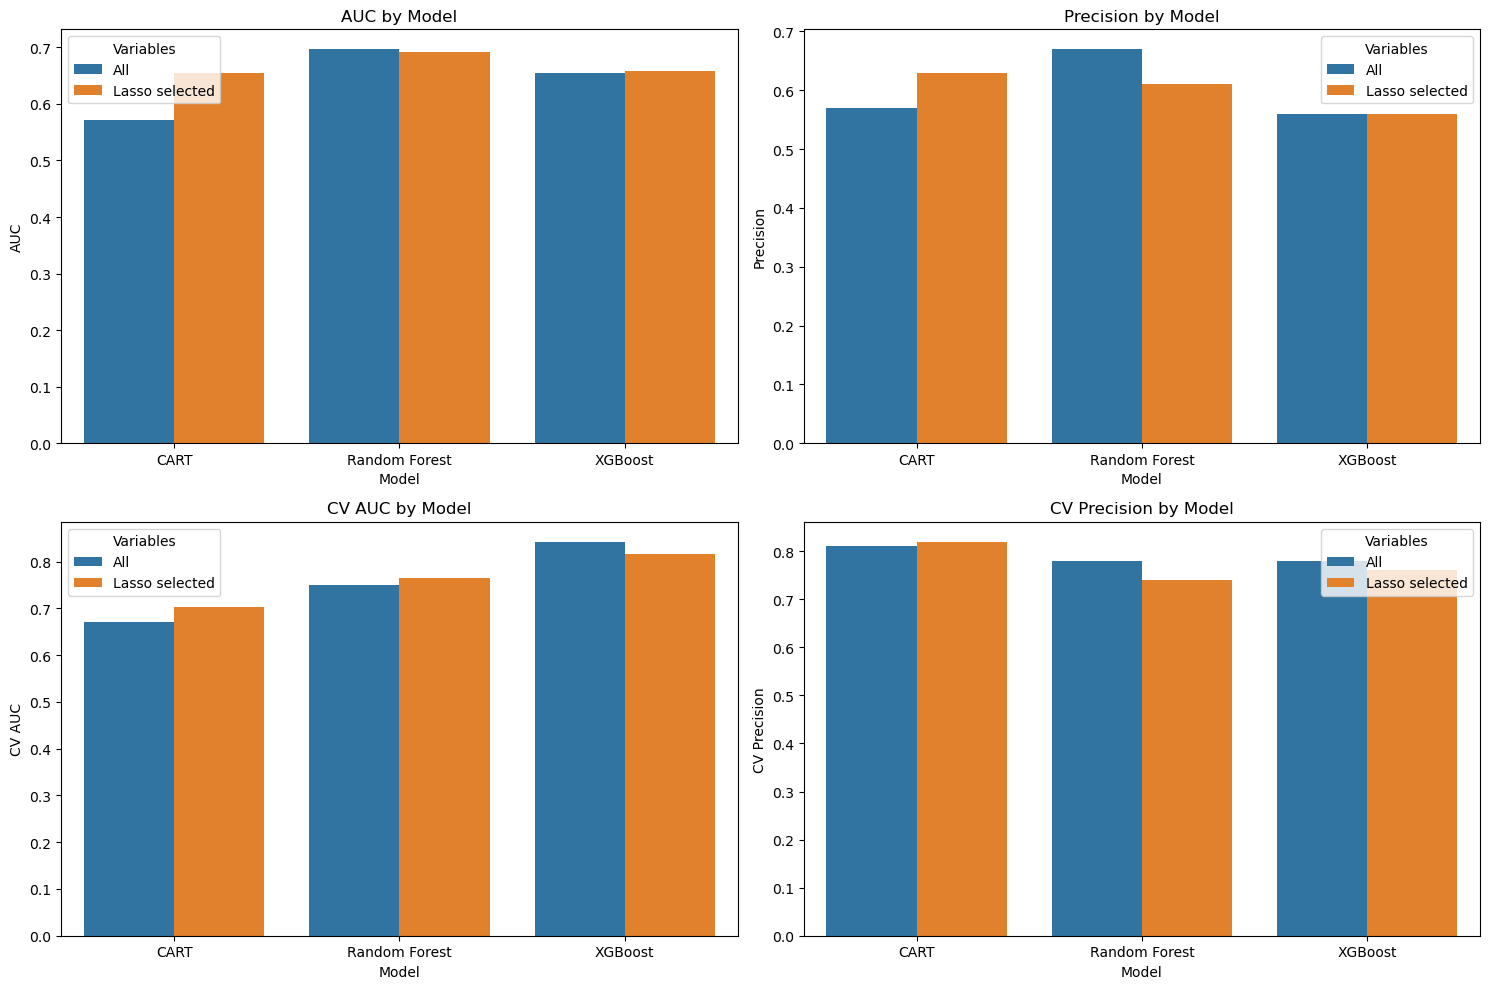

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Manually inputting the data based on the image provided
data = {
    "Model": ["CART", "Random Forest", "XGBoost", "CART", "Random Forest", "XGBoost"],
    "Variables": ["All", "All", "All", "Lasso selected", "Lasso selected", "Lasso selected"],
    "AUC": [0.572, 0.697, 0.655, 0.654, 0.691, 0.658],
    "Precision": [0.57, 0.67, 0.56, 0.63, 0.61, 0.56],
    "CV AUC": [0.670, 0.749, 0.843, 0.702, 0.766, 0.817],
    "CV Precision": [0.81, 0.78, 0.78, 0.82, 0.74, 0.76],
    "CV Precision (0)": [0.56, 0.77, 0.74, 0.63, 0.95, 0.78]
}

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(15, 10))

# AUC
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='AUC', hue='Variables', data=df)
plt.title('AUC by Model')

# Precision
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Precision', hue='Variables', data=df)
plt.title('Precision by Model')

# CV AUC
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='CV AUC', hue='Variables', data=df)
plt.title('CV AUC by Model')

# CV Precision
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='CV Precision', hue='Variables', data=df)
plt.title('CV Precision by Model')

plt.tight_layout()
plt.show()


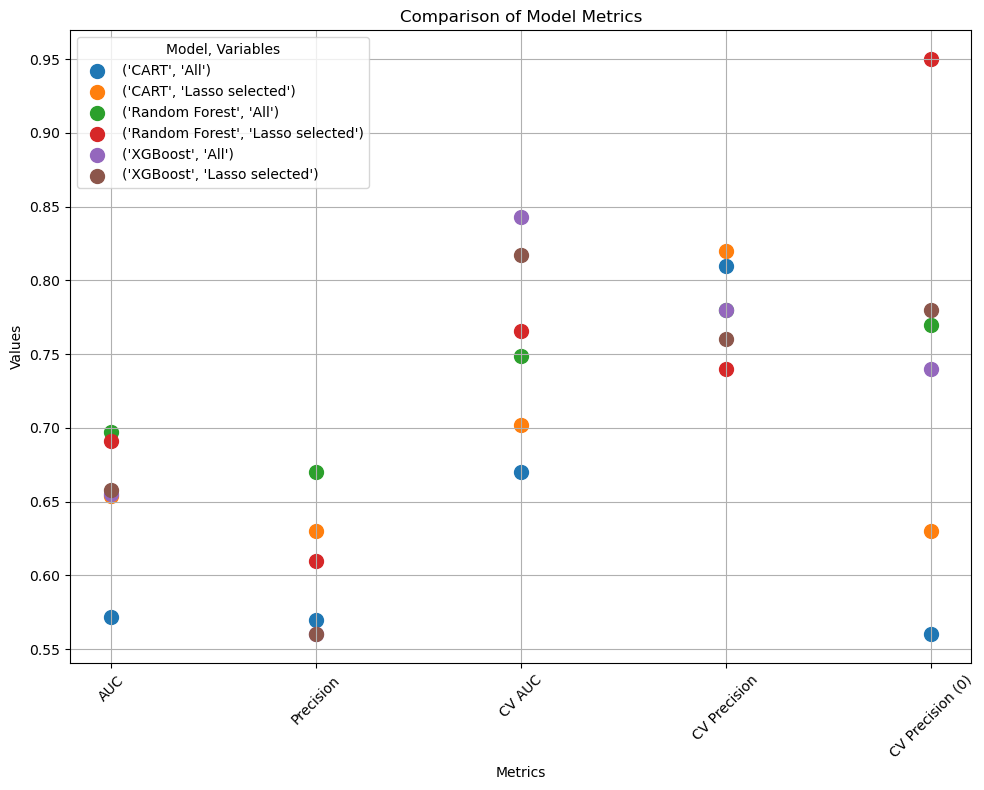

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is the DataFrame with your data as I have structured it previously

# Melt the DataFrame to have a long-form DataFrame suitable for sns.scatterplot
df_long = pd.melt(df, id_vars=['Model', 'Variables'], 
                  value_vars=['AUC', 'Precision', 'CV AUC', 'CV Precision', 'CV Precision (0)'])

# Now, plot the scatter plot
plt.figure(figsize=(10, 8))
for key, grp in df_long.groupby(['Model', 'Variables']): 
    plt.scatter(grp['variable'], grp['value'], label=key, s=100)

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of Model Metrics')
plt.legend(title='Model, Variables')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


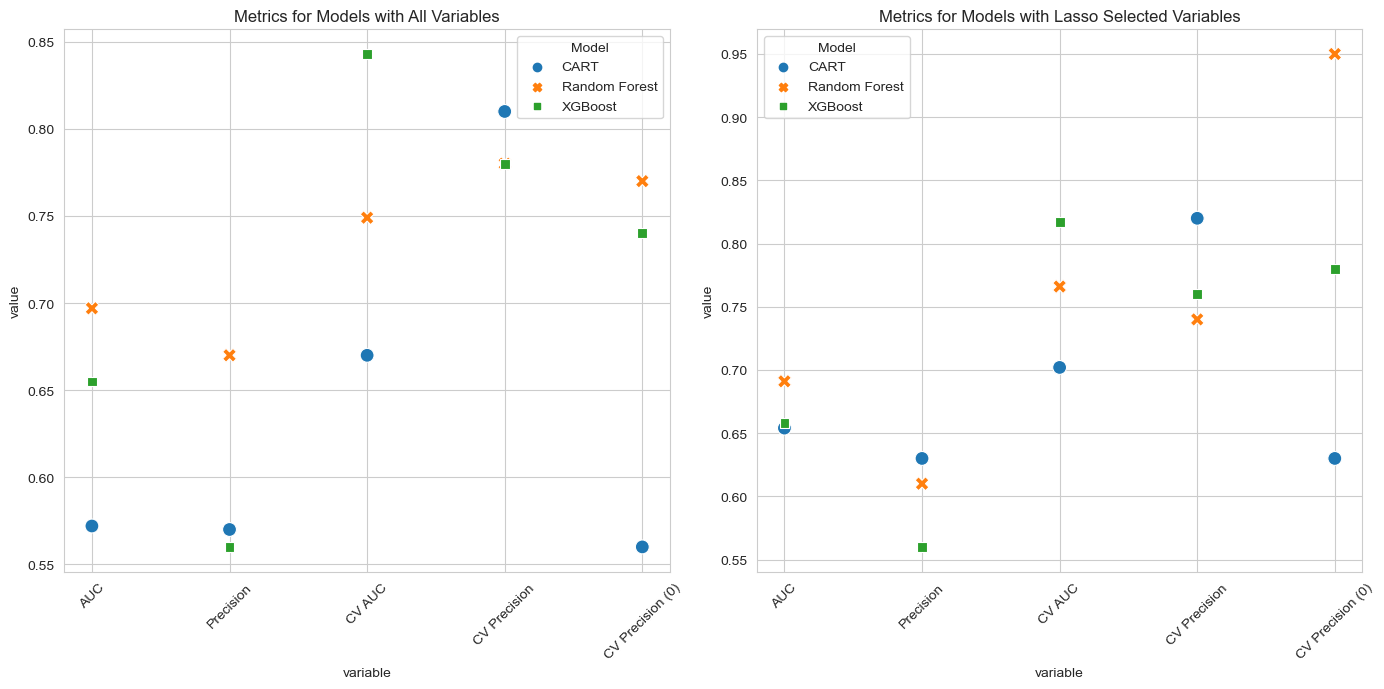

In [43]:
# We'll use the seaborn library for plotting which provides more flexibility and better aesthetics
import seaborn as sns

# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

# First, let's split the data into two separate DataFrames based on the 'Variables' column
df_all_variables = df[df['Variables'] == 'All']
df_lasso_selected = df[df['Variables'] == 'Lasso selected']

# Melt the dataframes into a long format for seaborn to plot
df_all_long = pd.melt(df_all_variables, id_vars=['Model'], 
                      value_vars=['AUC', 'Precision', 'CV AUC', 'CV Precision', 'CV Precision (0)'])

df_lasso_long = pd.melt(df_lasso_selected, id_vars=['Model'], 
                        value_vars=['AUC', 'Precision', 'CV AUC', 'CV Precision', 'CV Precision (0)'])



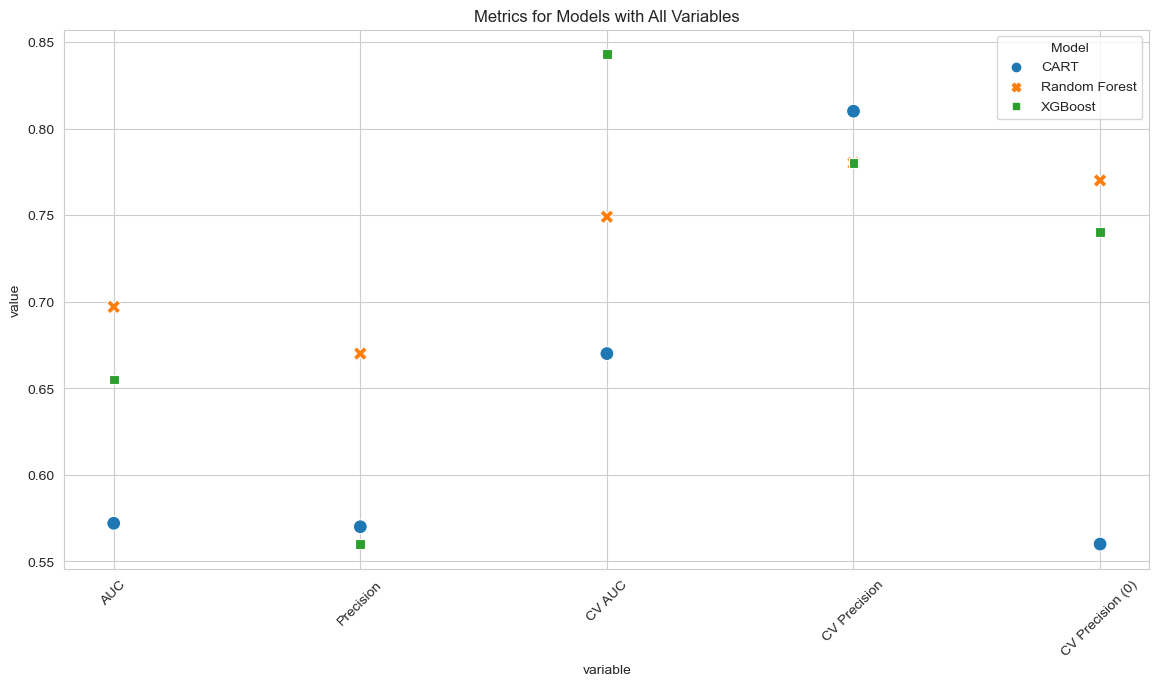

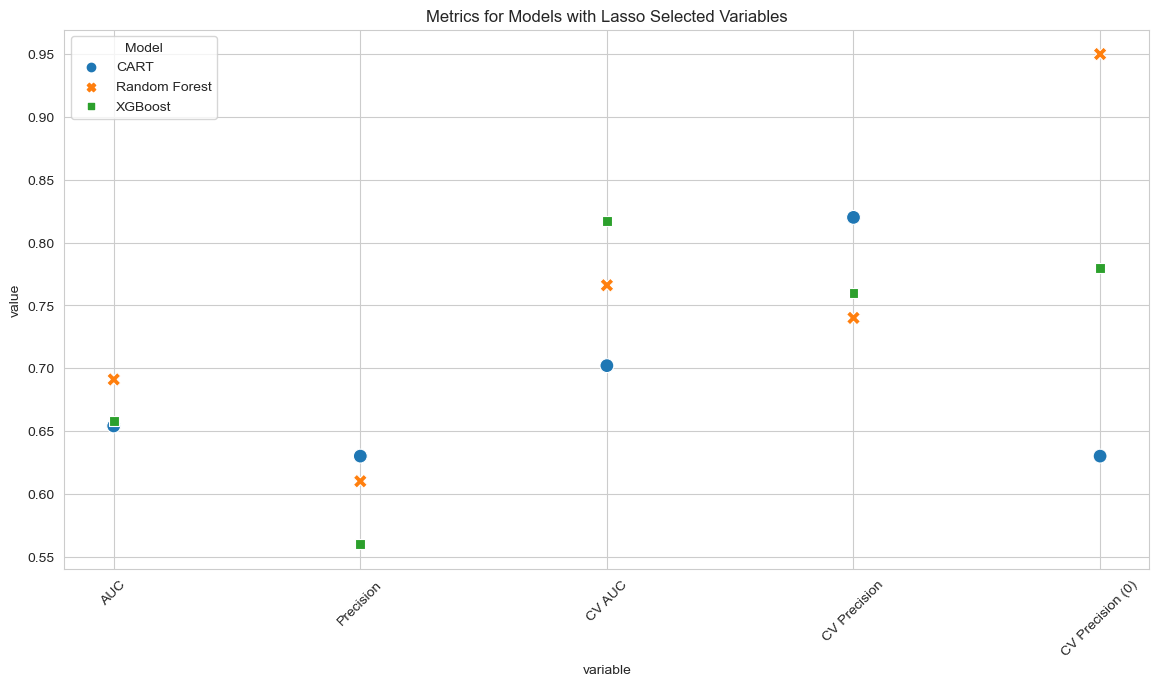

In [45]:
# Plot for models with all variables
plt.figure(figsize=(14, 7))
# plt.subplot(1, 2, 1)
sns.scatterplot(data=df_all_long, x='variable', y='value', hue='Model', style='Model', s=100)
plt.title('Metrics for Models with All Variables')
plt.xticks(rotation=45)
plt.show()

# Plot for models with Lasso selected variables
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df_lasso_long, x='variable', y='value', hue='Model', style='Model', s=100)
plt.title('Metrics for Models with Lasso Selected Variables')
plt.xticks(rotation=45)

# Adjust the layout
# plt.tight_layout()

# Show the plot
plt.show()
